# Deep Recurrent Learning (N-BEATS) vs. Traditional Machine Learning
## Advanced Machine Learning in Finance - Individual Project

The aim of this project is to compare the performance of two machine learning models, N-Beats and RandomForests, for predicting sales figures. The challenge is to use available data that has a correlation with the sales of various companies, such as credit card transactions to predict the quarterly sales figures.

The goal is to compare the accuracy of predictions for the current quarter, as well as the next couple of quarters, between N-Beats and RandomForests.

N-Beats is a deep learning model designed specifically for time-series forecasting, while RandomForests is a popular tree-based model used for various types of predictive modeling. This project aim to give insights into comparative forecasting results from these two models and their applications in the field of sales prediction.

The outcome of this project will be a comparison between the two models, including a discussion of the results and their implications for businesses and organizations looking to improve their financial forecasting capabilities.

In [1]:
import darts
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch 
import os
import sys
import sklearn 
import torch
from utils import DataFrameProcessor, ModelPipeline
import utils
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
)
from darts import TimeSeries
import darts.metrics as metrics
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

# Data Extraction

In [2]:
processor = DataFrameProcessor('exabel_data')

In [3]:
# / TODO add covid data as it may be a strong covariate for the time series at question
processor.files

['revenue.xlsx', '.DS_Store', 'spend_amounts_aggregated.xlsx']

In [4]:
revenue = processor.create_df(processor.revenue)
spendings = processor.create_df(processor.spendings)
df = processor.merge_spendings_revenue(spendings, revenue)
df = processor.create_stationary_covariates(df)
df = processor.encode_index(df)
df = processor.remove_short_series(df)
df = processor.remove_missing_ground_truth(df)

## Data Exploration

In [5]:
df.shape

(3776, 10)

In [6]:
df.columns

Index(['mic', 'ticker', 'time', 'nw_total_sales_a_total',
       'nw_total_sales_b_total', 'Sales_Actual_fiscal',
       'Sales_Estimate_fiscal', 'year', 'month', 'quarter'],
      dtype='object')

In [7]:
# total number of companies
len(df['ticker'].unique())

228

In [8]:
df.isna().sum()

mic                        17
ticker                      0
time                        0
nw_total_sales_a_total    158
nw_total_sales_b_total    709
Sales_Actual_fiscal        58
Sales_Estimate_fiscal      91
year                        0
month                       0
quarter                     0
dtype: int64

#### Inspecting whether seasonality is justified with including data for companies with 10 rows of data (each row correspond to a fiscal quarter)

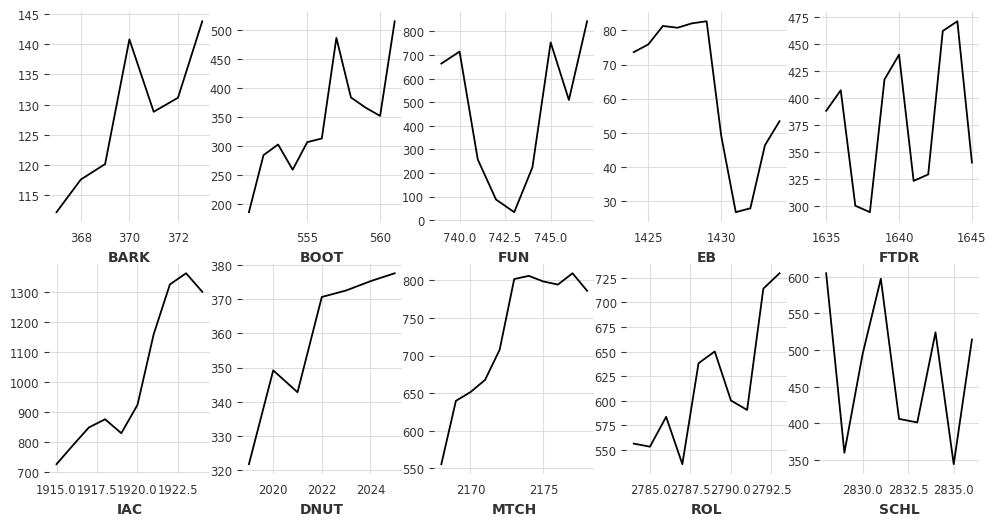

In [9]:
i, j = 0, 0
fig, ax = plt.subplots(2, 5, figsize=(12,6))

for tic in df['ticker'].unique():
    df_copy = df[df['ticker'] == tic]
    if df_copy.shape[0] < 12:
        ax[i][j].plot(df_copy['Sales_Actual_fiscal'])
        ax[i][j].set_xlabel(tic)
        j += 1
        if j == 5:
            j = 0
            i += 1
        if i == 2:
            break
        
plt.show()



In [10]:
processor.print_nans_companies(df)



Ticker: AAL, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AAN, # Data points: 12
Column: Sales_Actual_fiscal, NaN Indices: [0, 1]
Column: Sales_Estimate_fiscal, NaN Indices: [0, 1, 2]


Ticker: AAP, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 3]


Ticker: AAPL, # Data points: 17
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: ACI, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]
Column: Sales_Actual_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5]
Column: Sales_Estimate_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5, 6]


Ticker: AD, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 3]


Ticker: ADBE, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AEO, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AEP, # Data points: 14
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1

We see that the vast majority of missing vals are happening in the column 'nw_total_sales_b_total' for the indices in some form of subset of [0,1,2,3] so that it makes sense to impute these values to avoid missing large amounts of data.

/Users/eirikbaekkelund/Desktop/UCL/Code/FinanceTradingApps/project_adv_ml/utils.py:601: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df.corr(), fignum=f.number)


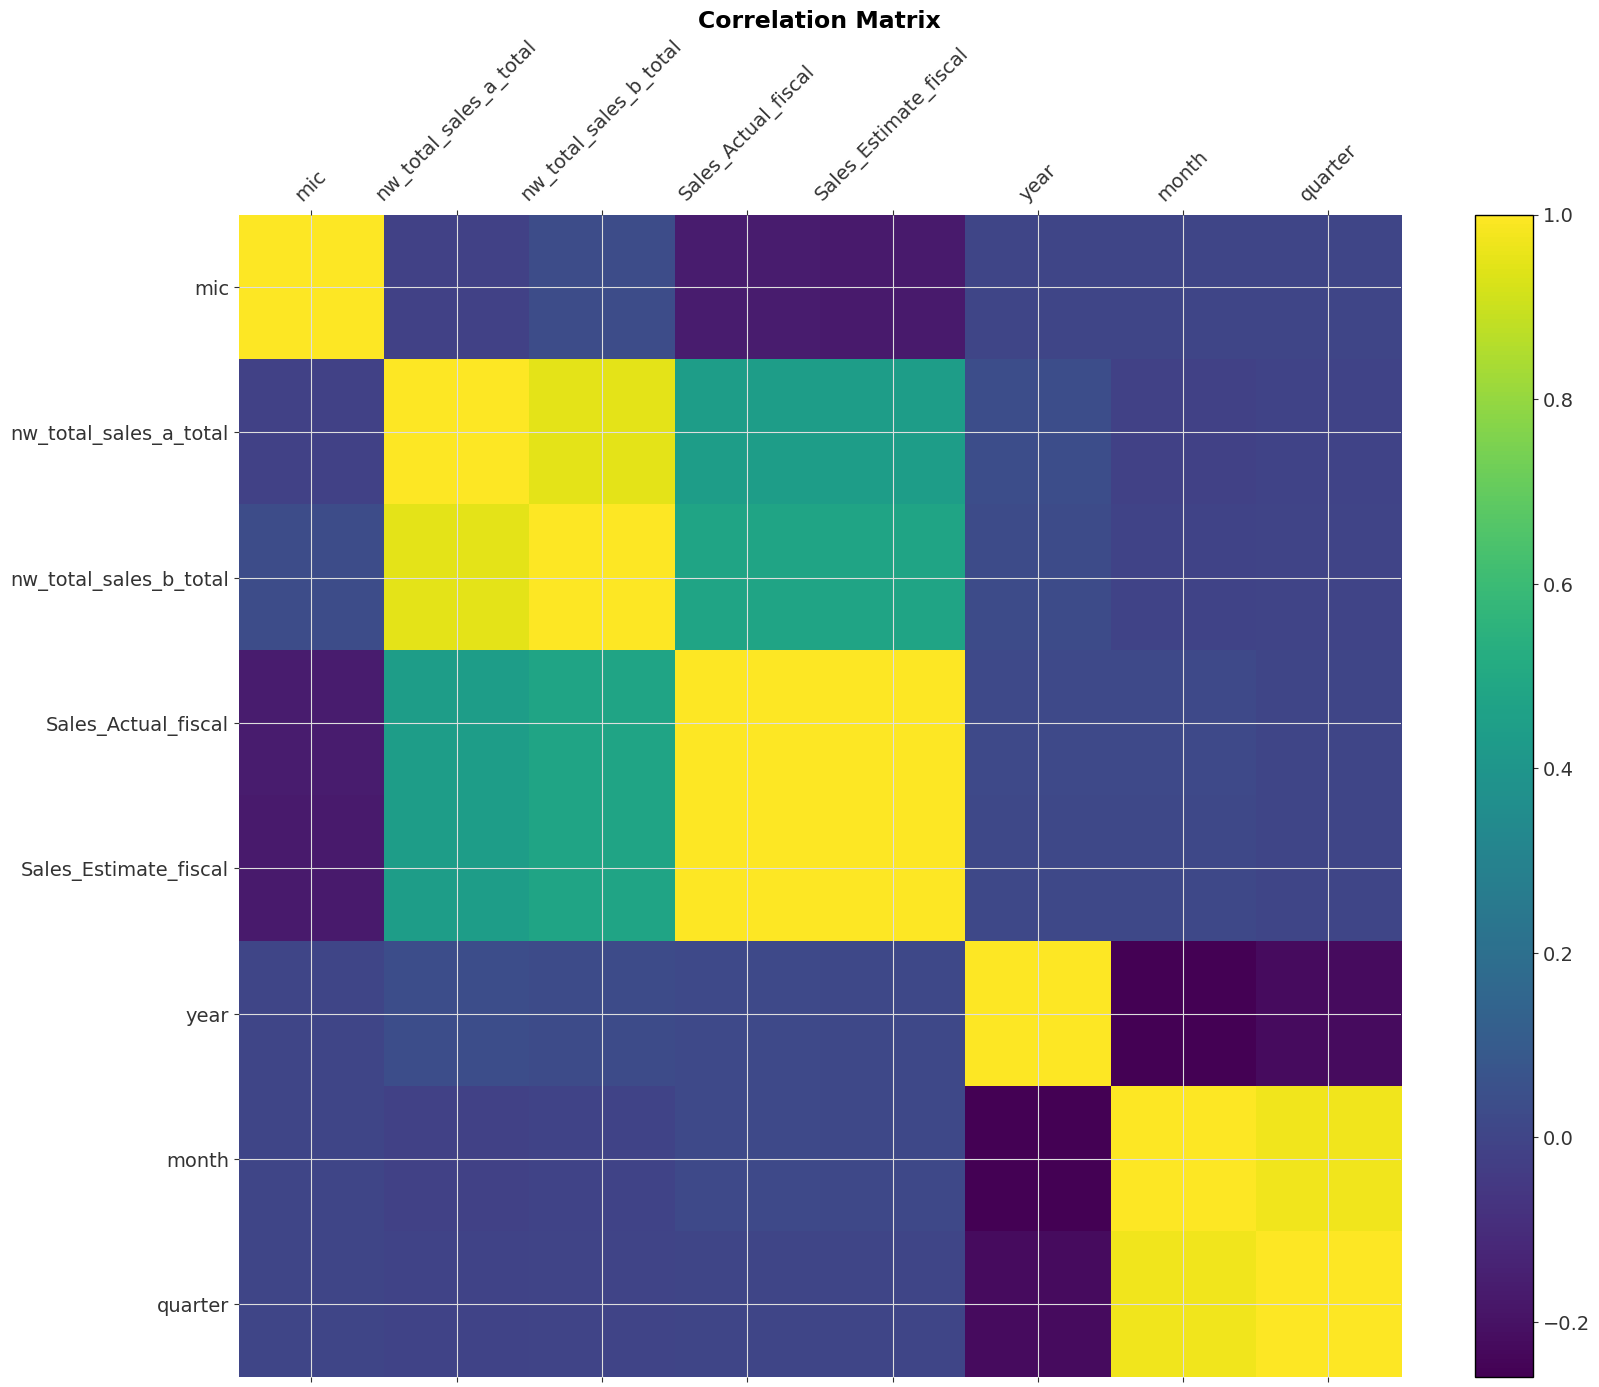

In [11]:
utils.plot_correlation_matrix(df);

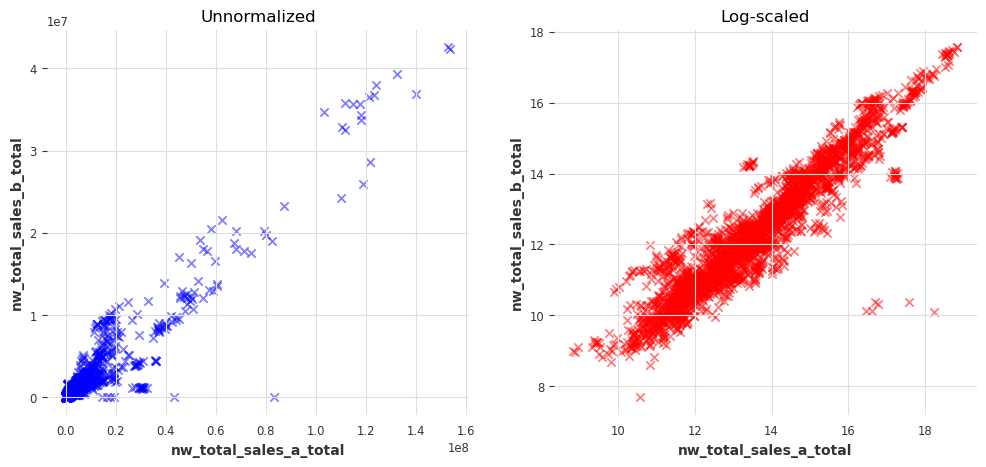

In [12]:
utils.plot_scatter_log(df,'nw_total_sales_a_total', 'nw_total_sales_b_total')

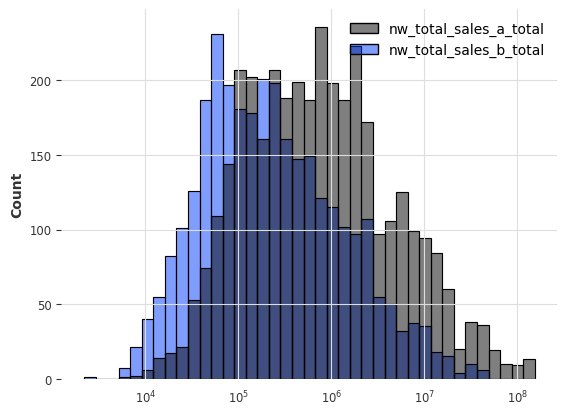

In [13]:
utils.plot_hist(df, 'nw_total_sales_a_total','nw_total_sales_b_total' )


We see that the distributions are quite similar but shifted, and that they have a fairly linear relationship when we apply the log. Thus, a linear least squares approach is justified. Including the other columns give a higher degree of freedom, but it could be justified to just use these columns up against each other.

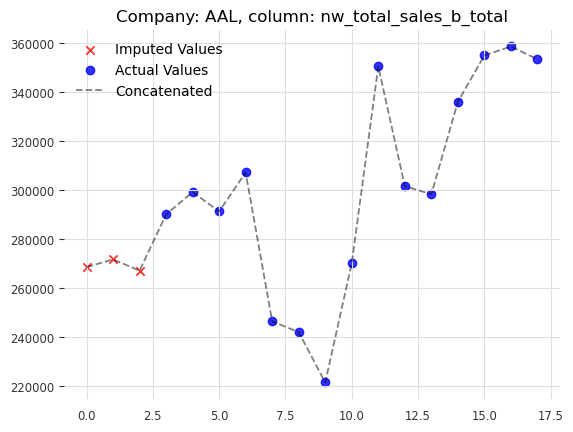

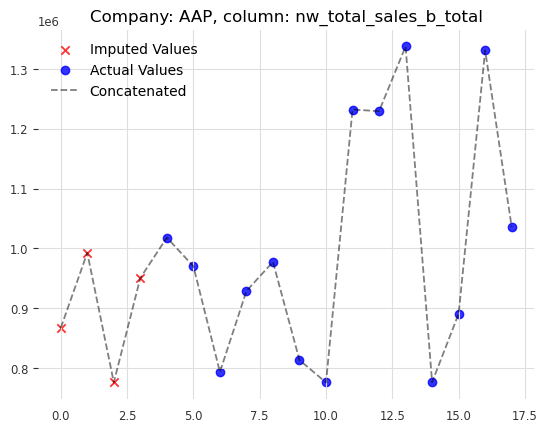

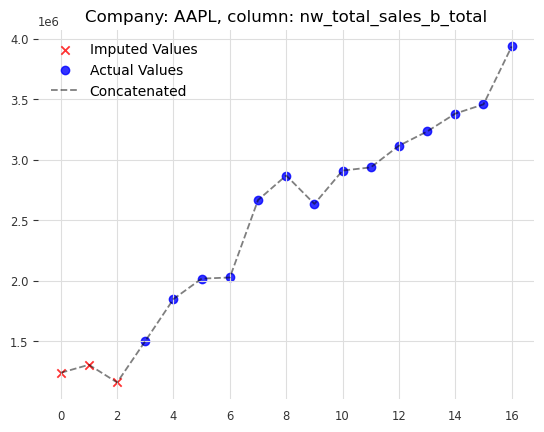

In [14]:
df = processor.impute_nans_singular_column(df, col='nw_total_sales_b_total' ,plot=True, max_plots=3)

Based on the plots a LLS solution looks sensible to the following time series, and thus handles many of the missing datapoints. The accuracy of these are however unknown. Bayesian regression can be performed to quantify uncertainty on the imputation on the missing values. To avoid noisy inputs, one could also perform lasso/ridge regression to shrink mutual information features and reduce high variance issues.   

In [15]:
df.isna().sum()

mic                        17
ticker                      0
time                        0
nw_total_sales_a_total    158
nw_total_sales_b_total    192
Sales_Actual_fiscal        58
Sales_Estimate_fiscal      91
year                        0
month                       0
quarter                     0
dtype: int64

We see that the Actual and Estimated sales for fiscal quarters have a decent amount of NaN values. Thus, we can statistically inspect them as well, and see if there are favorable methods of imputation of these.

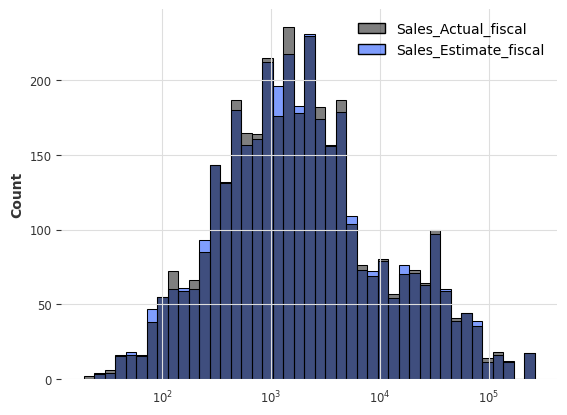

In [16]:
utils.plot_hist(df, 'Sales_Actual_fiscal', 'Sales_Estimate_fiscal')

The distributions have a very large overlap. Note that the distribution is a concetanation of all companies, so even though this looks normal, it is not necessarily the case for the distribution of actual sales and estimated sales with respect to the company in question.

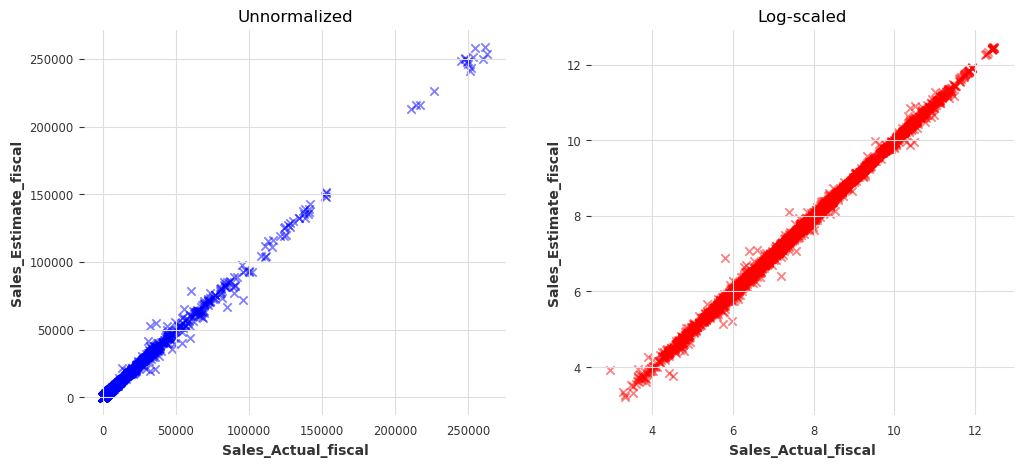

In [17]:
utils.plot_scatter_log(df, 'Sales_Actual_fiscal', 'Sales_Estimate_fiscal')

From this it looks as they are very linearly correlated. Let's inspect how it looks like for respective companies

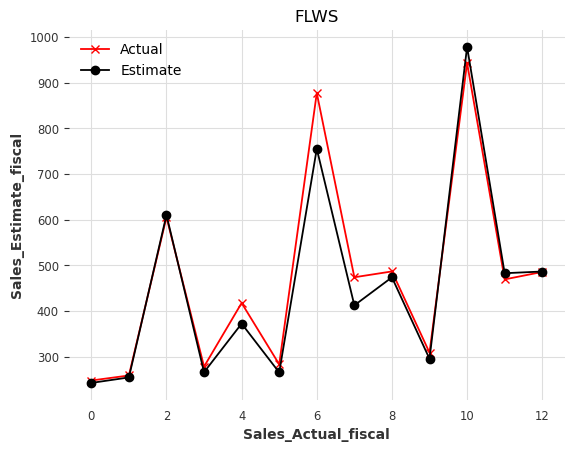

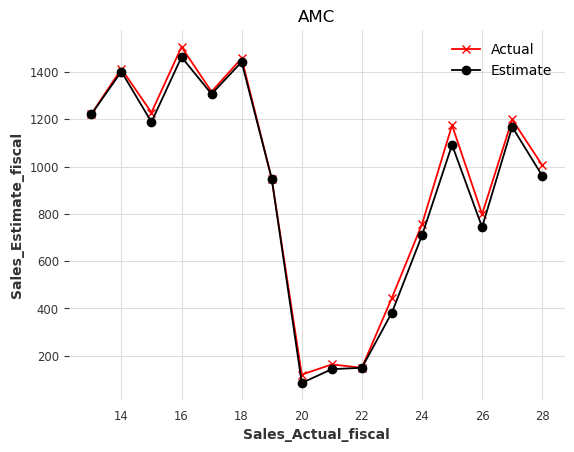

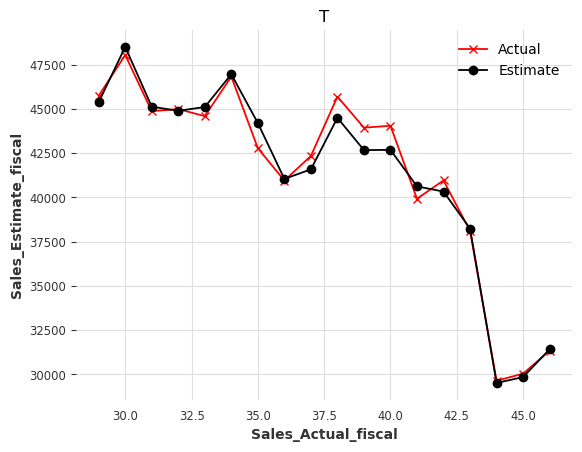

In [18]:
utils.plot_sales_comparison(df, max_plots=3)

It is evident that there are many instances for which the fiscal sales are missing for both estimate and actual, for that reason, we should apply an algorithm that can impute the missing values well. When both have NaNs at the same index over a time span ~5 there are uncertainty with doing rolling averages as there are fluctuations between quarters for many companies. The suggested idea would be to that of a KNN or KD-Ball algorithm to replace these instances. However, for the instances when there are rows when one or the other is present, it makes sense to impute values based on the other. Applying a normal centered at the no NaN column value at the corresponding index with a standard deviation that is the square root of the absolute difference of numeric rows seems like a intuitive and good solution based on their distribution. Also, when there is just a singular column of these with NaN values after doing the computations, we can perform LLS like earlier on those columns, given linearity exists in the dataset for these instances.

In [19]:
df = processor.fiscal_sales_imputation(df, plot=False)

### Remaining NaNs

In [20]:
df.isna().sum()

mic                        17
ticker                      0
time                        0
nw_total_sales_a_total    158
nw_total_sales_b_total    192
Sales_Actual_fiscal         0
Sales_Estimate_fiscal       0
year                        0
month                       0
quarter                     0
dtype: int64

For many of the total sales in A and B these are overlapping. A strategy here could be to use KNN / KD-Balls, Decision Trees or other ML algorithms for imputations

In [21]:
processor.print_nans_companies(df)



Ticker: ACI, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AEP, # Data points: 14
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


Ticker: ASO, # Data points: 15
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 6, 7, 8, 11, 12, 14]


Ticker: BARK, # Data points: 9
Column: nw_total_sales_b_total, NaN Indices: [2, 3, 4, 5, 6, 7, 8]


Ticker: BJRI, # Data points: 17
Column: nw_total_sales_a_total, NaN Indices: [7]
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 15]


Ticker: BKE, # Data points: 12
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


Ticker: BOOT, # Data points: 11
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Ticker: CAR, # Data points: 17
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 6, 7, 9]


Ticker: CASY, # Data points: 17
Column: nw_total_sales_a_total, NaN Indices: [2]
Column: nw_total_sa

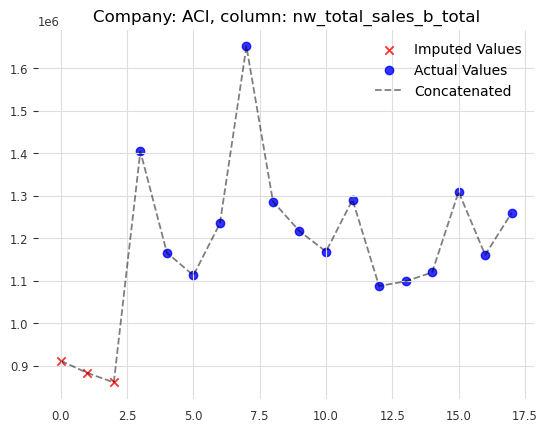

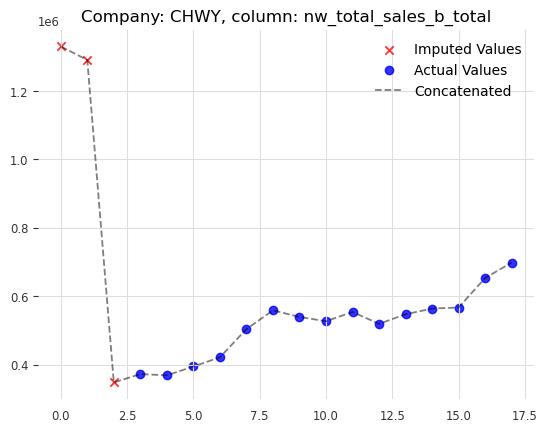

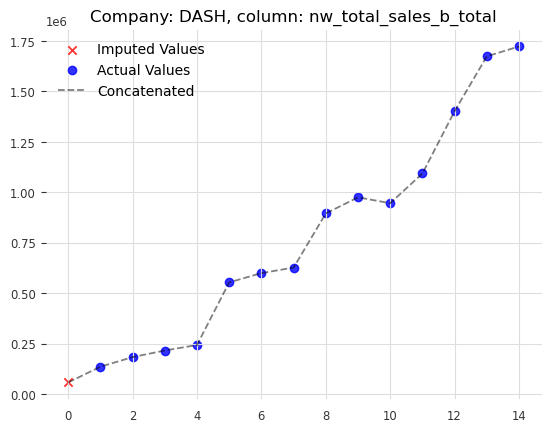

In [22]:
df = processor.impute_nans_singular_column(df, col='nw_total_sales_b_total',plot=True, max_plots=3)

It can seem as this is cause for some anomolies when performing LLS. Let's create a pipeline to detect anomolies.

In [23]:
df.ticker.unique()

array(['FLWS', 'AMC', 'T', 'ANF', 'ASO', 'ATVI', 'ADBE', 'AAP', 'ACI',
       'GOOGL', 'ATUS', 'AMZN', 'AMXL', 'AAL', 'AEO', 'AEP', 'AAPL',
       'ARMK', 'AZO', 'CAR', 'BARK', 'BJRI', 'BJ', 'BP', 'BBWI', 'BBBY',
       'BBY', 'BIG', 'SQ', 'BLMN', 'BKNG', 'BOOT', 'EAT', 'BBW', 'BURL',
       'CVS', 'CAL', 'CTLP', 'CPRI', 'CCL', 'CRI', 'CASY', 'FUN', 'CHTR',
       'CAKE', 'CHGG', 'CVX', 'CHWY', 'CHS', 'CMG', 'CHH', 'CMPR', 'CNK',
       'CTRN', 'CMCSA', 'COP', 'COST', 'CBRL', 'CROX', 'CUBE', 'DISH',
       'DRI', 'PLAY', 'DAL', 'DENN', 'DBI', 'DKS', 'DDS', 'DIN', 'DG',
       'DLTR', 'DPZ', 'DASH', 'DKNG', 'DBX', 'DLTH', 'EA', 'EL', 'ETSY',
       'EB', 'ES', 'EXPE', 'EXPR', 'XOM', 'FDX', 'FIVE', 'FVRR', 'FLTR',
       'FL', 'FTV', 'FRG', 'FTDR', 'ULCC', 'GME', 'GPS', 'GEN', 'GM',
       'GCO', 'GPC', 'GDDY', 'GRPN', 'HOG', 'HLF', 'HIBB', 'HLT', 'HUM',
       'H', 'IAC', 'INTU', 'JACK', 'JBLU', 'KSS', 'AD', 'DNUT', 'MC',
       'LEVI', 'LYV', 'LOW', 'LYFT', 'M', 'MPC', 'MAR', 'MTCH', '

<AxesSubplot: xlabel='month', ylabel='Sales_Actual_fiscal'>

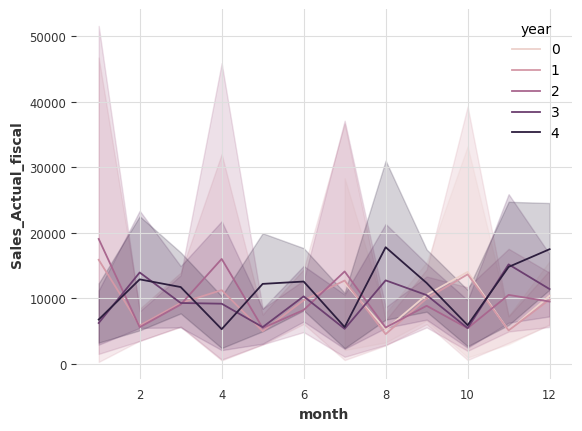

In [24]:
sns.lineplot(data=df, x='month', y='Sales_Actual_fiscal', hue='year')

The lower years observed here are 2021 and 2022 (data starts in 2018), thus it will make sense that we see the hit the economy took

In [25]:
df = processor.impute_nans_singular_column(df)

In [26]:
df = df.dropna(how='any')
df = processor.remove_short_series(df)
df.shape

(3384, 10)

# Scaling Data
Now, we have large discrepencies between the values for each column. Thus, it makes sense to normalize them and rather scale up after making predictions. 

### After Scaling
We can start by defining columns that can unveil underlying correlations. In doing so, we allow the network to find complex patterns within the data that otherwise would not have been unveiled

/Users/eirikbaekkelund/Desktop/UCL/Code/FinanceTradingApps/project_adv_ml/utils.py:601: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df.corr(), fignum=f.number)


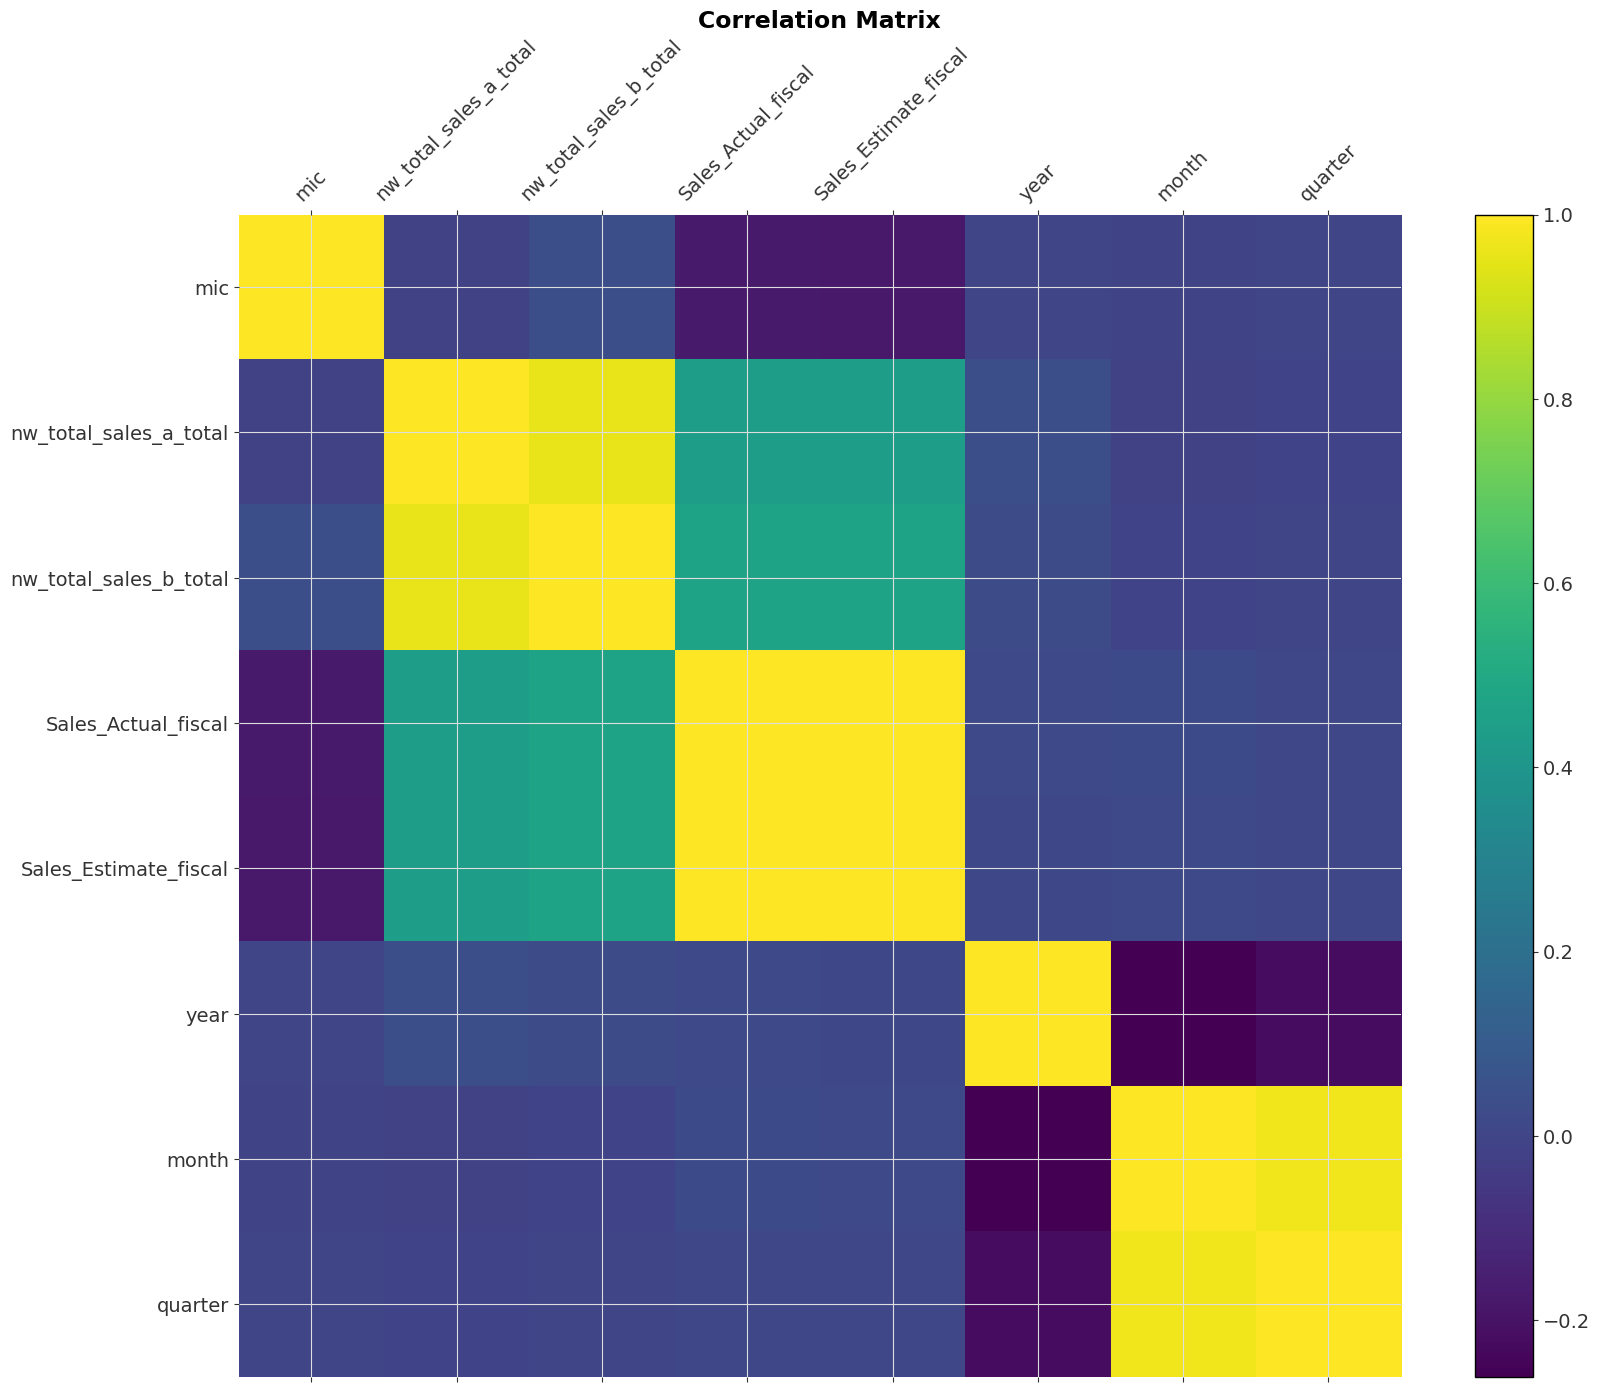

In [27]:
utils.plot_correlation_matrix(df)

In [28]:
df.columns

Index(['mic', 'ticker', 'time', 'nw_total_sales_a_total',
       'nw_total_sales_b_total', 'Sales_Actual_fiscal',
       'Sales_Estimate_fiscal', 'year', 'month', 'quarter'],
      dtype='object')

## Adding features and removing uncorrelated features w.r.t. target

/Users/eirikbaekkelund/Desktop/UCL/Code/FinanceTradingApps/project_adv_ml/utils.py:601: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df.corr(), fignum=f.number)


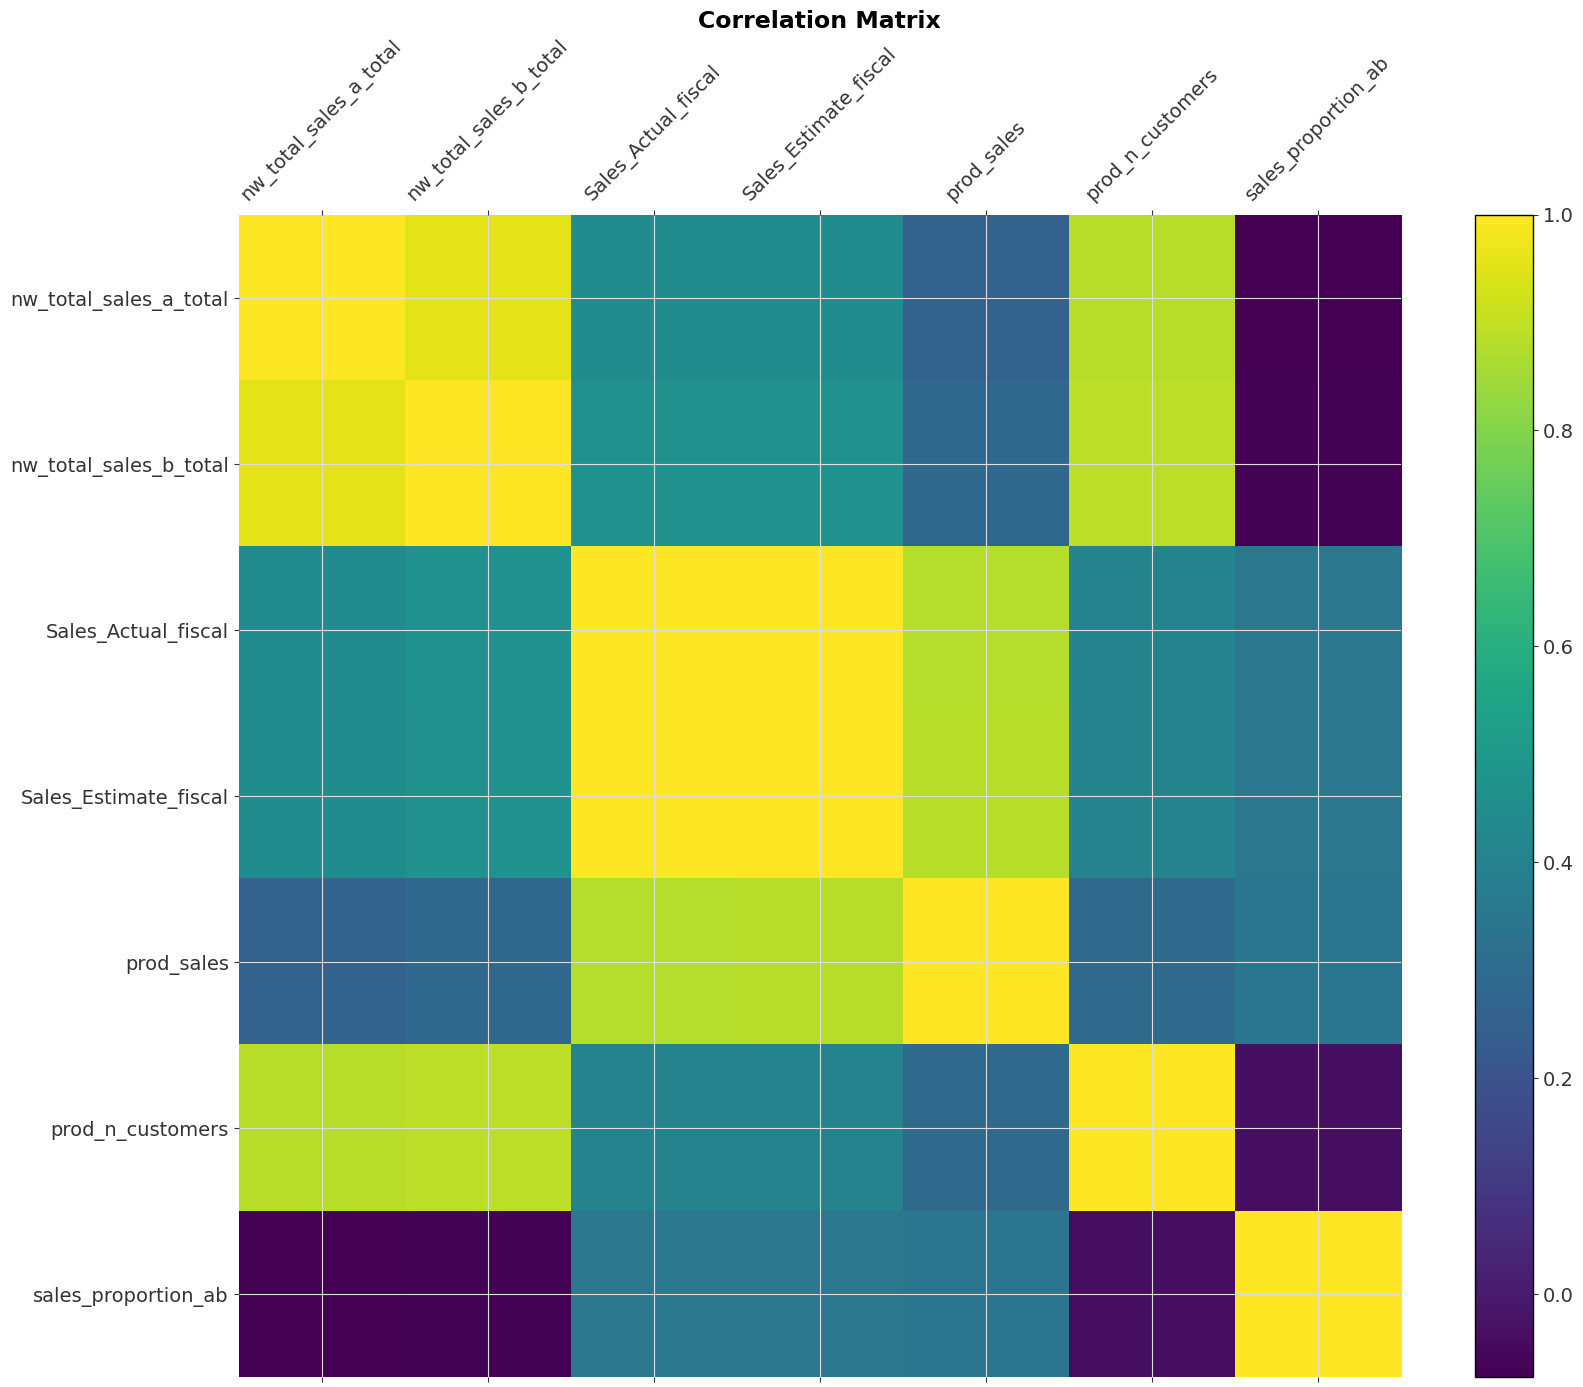

In [29]:
df = processor.add_prod(df)
df['sales_proportion_ab'] = df['Sales_Actual_fiscal'] / (df['nw_total_sales_a_total'] + df['nw_total_sales_b_total'])
df = df.drop(['year', 'month', 'quarter', 'mic'], axis=1)
utils.plot_correlation_matrix(df)

# Building Series in Darts
Note that the data frame must be thoroughly processed before starting this process, and keep in mind to that the model actually does handle NaNs implicitly. So, the thorough removal may not be neccessary. Especially, the line when all NaNs are dropped. Darts also has it's own models for imputations, but due to the structure of the data in this project, manual imputation using simple statistics was done.

In [30]:
from darts.models import BlockRNNModel, RandomForest
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, rmse

In [31]:
def remove_time_cols(df):
    """ 
    
    """
    # these columns could be used as static covariates for the forecasting process
    # except from the ticker (tag of company at exchange)
    cols_to_drop = ['month', 'quarter', 'ticker', 'mic']
    df.drop(cols_to_drop, axis=1, errors='ignore', inplace=True)
    return df

def set_df_index(df):
    """ 
    
    """
    df = df.copy()
    df = remove_time_cols(df)
    df = df.reset_index(drop=True)
    
    return df

def scale_series(series):
    """ 
    
    """
    scaler = Scaler()
    scaler.fit_transform(series)
    series = scaler.transform(series)

    series = series.astype(np.float64)

    return series


def convert_df_to_series(df,covariates=['nw_total_sales_a_total','nw_total_sales_b_total','Sales_Estimate_fiscal'], target='Sales_Actual_fiscal'):
    """ 
    
    """
    df = df.copy()
    df = remove_time_cols(df)
    df = df.reset_index(drop=True)
    
    if covariates is None:
        covariates = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
        
        try:
            covariates.remove(target)        
        except ValueError:
            pass
    
    covs = TimeSeries.from_dataframe(df, value_cols=covariates, freq='Q')
    target = TimeSeries.from_dataframe(df,value_cols=target, freq='Q')
    
    covs = scale_series(covs)
    target = scale_series(target)
    
    return covs, target

def get_covs_target_dict(df, covariates=None, target='Sales_Actual_fiscal'):
    """ 
    
    """
    
    ticker_series =  {tic : set_df_index(df[df['ticker'] == tic]) for tic in df.ticker.unique()}
    
    return {tic : convert_df_to_series(ticker_series[tic], covariates=covariates, target=target) for tic in ticker_series.keys()}

def drop_short_sequences(series_dict, min_length = 15):
    """ 
    
    """
    return {key : vals for key, vals in series_dict.items() if vals[0].data_array().shape[0] > min_length}
    
def slice_series(covariates, target, proportion=0.9):
    """ 
    
    """
    n_split = int( len(target.data_array())*proportion )
    
    target_train, target_test = target[:n_split], target[n_split:]
    past_covariates, future_covariates = covariates[:n_split], covariates[n_split:]

    return past_covariates, future_covariates, target_train, target_test

def split_covariates_target(covariates, target, proportion=0.9):
    """ 
    
    """
    past_covariates, future_covariates = covariates.split_before(proportion)
    target_train, target_test = target.split_before(proportion)
    return past_covariates, future_covariates, target_train, target_test

def model_input(series_dict, train_style='slice'):
    """ 
    
    """
    assert train_style in ['slice', 'split'], "need to have train_style set to either slice or split"

    if train_style == 'slice':
        covs_past, covs_future, targets_train, targets_test = zip(*[slice_series(series_dict[tic][0], series_dict[tic][1]) for tic in series_dict.keys()])
        covs_past = list(covs_past)
        covs_future = list(covs_future)
        targets_train = list(targets_train)
        targets_test = list(targets_test)
        tickers = list(series_dict.keys())
    else:
        covs_past, covs_future, targets_train, targets_test = split_covariates_target(series_dict[tic][0], series_dict[tic][1])
        tickers = list(series_dict.keys())  
    return covs_past, covs_future, targets_train, targets_test, tickers

def get_input_output_chunks(series_train, series_test):
    
    min_length_train, min_length_test = np.inf, np.inf

    for train, test in zip(series_train, series_test):
        length_train = len(train.data_array())
        length_test = len(test.data_array())
        
        if length_train < min_length_train:
            min_length_train = length_train
        
        if length_test < min_length_test:
            min_length_test = length_test
        
    min_length_train = min_length_train - min_length_test
    
    return min_length_train, min_length_test

def set_test_length(series_test, t_test):
    return [serie[:t_test] for serie in series_test]
   

Functions above help extract appropriate covariates and target for each company within the data frame

In [32]:
list(df.columns)

['ticker',
 'time',
 'nw_total_sales_a_total',
 'nw_total_sales_b_total',
 'Sales_Actual_fiscal',
 'Sales_Estimate_fiscal',
 'prod_sales',
 'prod_n_customers',
 'sales_proportion_ab']

### Converting the data frame into series for each company

In [33]:
train_style = 'slice'
series_dict = get_covs_target_dict(df)
series_dict = drop_short_sequences(series_dict)
past_covariates, future_covariates, series_train, series_test, tickers = model_input(series_dict)
input_length, output_length = get_input_output_chunks(series_train, series_test)
series_test = set_test_length(series_test, t_test=output_length)
input_length, output_length

(12, 2)

## N-Beats settings

In [34]:
epochs = 200
blocks = 2*input_length # number of blocks in model        
layer_width = 32        # numer of weights in FC layer
batch = 2*input_length  # batch size
lr = 1e-3               # learning rate
val_wait = 1            # epochs to wait before evaluating the loss on the test/validation set
seed = 42               # random seed for regenerating results
n_samples = 100         # number of times a prediction is sampled from a probabilistic model
n_jobs = -1             # parallel processors to use;  -1 = all processors
split_proportion = 0.9  # train/test proportion

# quantiles for QuantileRegression argument
quantiles = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

# lower and upper quantiles for predictions
QL1, QL2 = 0.01, 0.05 
QU1, QU2 = 1 - QL1, 1 - QL2 
# labels for plotting
labelQ1 = f'{int(QU1 * 100)} / {int(QL1 * 100)} percentile band'
labelQ2 = f'{int(QU2 * 100)} / {int(QL2 * 100)} percentile band'


In [35]:
model = NBEATSModel(input_chunk_length=input_length, 
                     output_chunk_length=output_length,
                     num_stacks=blocks,
                     layer_widths=layer_width,
                     n_epochs=epochs,
                     likelihood = QuantileRegression(quantiles),
                     optimizer_kwargs = {"lr" : 1e-3},
                     generic_architecture=True,
                     trend_polynomial_degree=2,
                     random_state=seed,
                     nr_epochs_val_period=val_wait,
                   
                     )
predictor = model.fit(series=series_train, 
                       past_covariates=past_covariates,               
                       verbose=True,
                       epochs=epochs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 187 K 
---------------------------------------------------
186 K     Trainable params
669       Non-trainable params
187 K     Total params
1.497     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


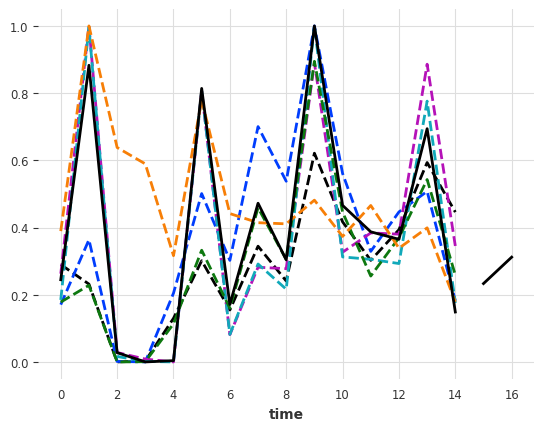

In [36]:
def plot_series_covs(covariates, series_train, series_test, idx):
    covariates[idx].plot(label='past covariates', linestyle='--')
    series_train[idx].plot(color='black')
    series_test[idx].plot(color='black')
    plt.legend().set_visible(False)
    plt.show()

plot_series_covs(past_covariates, series_train, series_test, 3)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

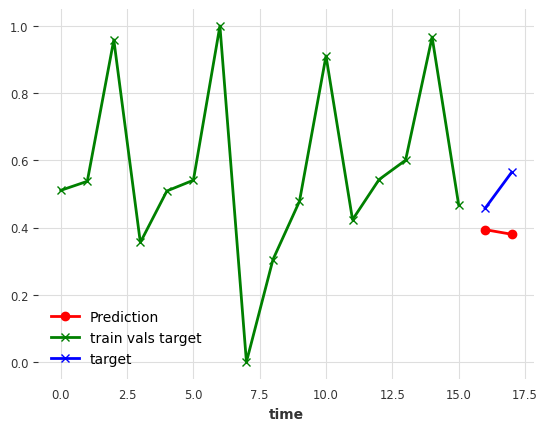

In [37]:
def plot_prediction(predictor, train, test, covs, idx, n_preds=2):
    pred = predictor.predict(series=series_train[idx],
                         n=n_preds, 
                         past_covariates=covs[idx],
                         n_jobs=-1)
    pred.plot(label='Prediction', marker='o', color='red', low_quantile=0.05, high_quantile=0.95)
    train[idx].plot(marker='x', color ='green', label='train vals target')
    test[idx].plot(marker='x', color ='blue', label='target')
    plt.legend();
    plt.show();

plot_prediction(predictor, series_train, series_test, past_covariates, idx=2, n_preds=output_length, )

In [38]:
print(output_length)

2


In [39]:
rmse

<function darts.metrics.metrics.rmse(actual_series: Union[darts.timeseries.TimeSeries, Sequence[darts.timeseries.TimeSeries]], pred_series: Union[darts.timeseries.TimeSeries, Sequence[darts.timeseries.TimeSeries]], intersect: bool = True, *, reduction: Callable[[numpy.ndarray], float] = <function mean at 0x1132d8d30>, inter_reduction: Callable[[numpy.ndarray], Union[float, numpy.ndarray]] = <function <lambda> at 0x179815280>, n_jobs: int = 1, verbose: bool = False) -> Union[float, numpy.ndarray]>

In [40]:

parameters = {
        "input_chunk_length" :  [2*output_length, 4*output_length],
        "output_chunk_length" : [output_length],
        "num_stacks" :          [1,2,3,4,5,10],
        "num_blocks" :          [1,2,3],
        "num_layers" :          [1,2],
        "layer_widths" :         [128,256],
        "n_epochs" :            [20],
        "nr_epochs_val_period" :[1],
        "batch_size" :          [128,256],
        "random_state" :        [1],
        
        }

result = NBEATSModel.gridsearch(
                parameters=parameters,
                series=series_train,
                forecast_horizon=output_length,
                metric=rmse,
                n_jobs=-1,
                last_points_only=True,
                verbose=True,
                n_random_samples=0.9)

  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 38.0 K
---------------------------------------------------
37.3 K    Trainable params
693       Non-trainable params
38.0 K    Total params
0.304     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

  0%|          | 0/171 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.00101, train_loss=4.41e-5]         

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 116 K 
---------------------------------------------------
115 K     Trainable params
1.3 K     Non-trainable params
116 K     Total params
0.933     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 38.46it/s, loss=0.000498, train_loss=3.14e-5] 


  0%|          | 0/171 [00:00<?, ?it/s]`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

GPU available: False, used: False
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 38.0 K
---------------------------------------------------
37.3 K    Trainable params
693       Non-trainable params
38.0 K    Total params
0.304     Total estimated model params size (MB)
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | 

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 38.0 K
---------------------------------------------------
37.3 K    Trainable params
693       Non-trainable params
38.0 K    Total params
0.304     Total estimated model params size (MB)
  0%|          | 0/171 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0229, train_loss=0.0127]        

  0%|          | 0/171 [00:00<?, ?it/s]GPU available: False, used: False
GPU available: False, used: False
GPU available: False, used: False
  0%|          | 0/171 [00:00<?, ?it/s]TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 10.0 K
---------------------------------------------------
9.3 K     Trainable params
693       Non-trainable params
10.0 K    Total params
0.080     Total estimated model params size (MB)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.82it/s]loss=5.900]



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 848 K 
---------------------------------------------------
847 K     Trainable params
1.3 K     Non-trainable params
848 K     Total params
6.790     Total estimated model params size (MB)

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 190 K 
---------------------------------------------------
189 K     Trainable params
693       Non-trainable params
190 K     Total params
1.521     Total estimated model params size (MB)
GPU available: False, used: False
`Trainer.fit` stopped: `max_epochs=2

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.548, train_loss=0.474]          

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 38.0 K
---------------------------------------------------
37.3 K    Trainable params
693       Non-trainable params
38.0 K    Total params
0.304     Total estimated model params size (MB)


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 76.96it/s, loss=0.471, train_loss=0.306]  

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 38.0 K
---------------------------------------------------
37.3 K    Trainable params
693       Non-trainable params
38.0 K    Total params
0.304     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPU

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.38, train_loss=0.183]             

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 35.0 K
---------------------------------------------------
33.7 K    Trainable params
1.3 K     Non-trainable params
35.0 K    Total params
0.280     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPU

Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.216, train_loss=0.0424]         

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 10.0 K
---------------------------------------------------
9.3 K     Trainable params
693       Non-trainable params
10.0 K    Total params
0.080     Total estimated model params size (MB)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | 

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

`Trainer.fit` stopped: `max_epochs=20` reached.
`Trainer.fit` stopped: `max_epochs=20` reached.
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
`Trainer.fit` stopped: `max_epochs=20` reached.
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELo

Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.0258, train_loss=0.00598]        


  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 190 K 
---------------------------------------------------
189 K     Trainable params
693       Non-trainable params
190 K     Total params
1.521     Total estimated model params size (MB)

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 35.0 K
---------------------------------------------------
33.7 K    Trainable params
1.3 K     Non-trainable params
35.0 K    Total params
0.280     Total estimated model params size (MB)
GPU available: False, used: False
TPU available: False, using: 0 TPU c

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]in_loss=0.0644]            

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 38.0 K
---------------------------------------------------
37.3 K    Trainable params
693       Non-trainable params
38.0 K    Total params
0.304     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params

Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.104, train_loss=0.0286]          

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 22.5 K
---------------------------------------------------
21.8 K    Trainable params
693       Non-trainable params
22.5 K    Total params
0.180     Total estimated model params size (MB)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPU

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.441, train_loss=0.185]         

`Trainer.fit` stopped: `max_epochs=20` reached.
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList 

Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, loss=0.668, train_loss=0.159]        

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 38.0 K
---------------------------------------------------
37.3 K    Trainable params
693       Non-trainable params
38.0 K    Total params
0.304     Total estimated model params size (MB)


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 14.84it/s, loss=0.407, train_loss=0.106]  

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 10.0 K
---------------------------------------------------
9.3 K     Trainable params
693       Non-trainable params
10.0 K    Total params
0.080     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=20` reached.
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
`Trainer.fit` stopped:

# Hyperparameter Tuning


### N-Beats / RNN (Architecture Design)  
* n_layers
* n_stacks
* input_chunk_length (lookback window of the model)
* output_chunk_length (how many steps into the future we make predictions)


In [ ]:
print(result)

In [ ]:
def eval_model(model, target, past_covariates=None, future_covariates=None, forecast_horizon=4, proportion_train=0.75):
    
    backtest = model.historical_forecasts(series=target, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.8, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon)
    print('RMSE = {}'.format(metrics.rmse(target, backtest)))

def grid_search(train_series,input_length, output_length, train_style='slice'):
    """ 
    
    """
    assert train_style in ['slice', 'split'], "need to have train_style set to either slice or split"
    # TODO - add splitting of series for doing grid search
    parameters = {
        "input_chunk_length" : [input_length - i for i in range(4)],
        "output_chunk_length" : [1,2],
        "num_stacks" : [1,2,3,4],
        "num_blocks" : None,
        "num_layers" : None,
        "layer_width" : None,
        "n_epochs" : None,
        "nr_epochs_val_period" : None,
        "batch_size" : None,
        "random_state" : [1],
        }
    if train_style == 'slice'
        result = NBEATSModel.gridsearch(
                parameters=parameters,
                series=train_series,
                start=input_length + 1,
                forecast_horizon=output_length,
                metric=rmse,
                n_jobs=-1,
                last_points_only=True,
                verbose=True,
                n_random_samples=0.9)